### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP на implicit данных

Мягкий дедлайн 13 Октября (пишутся замечания, выставляется оценка, есть возможность исправить до жесткого дедлайна)

Жесткий дедлайн 20 Октября (Итоговая проверка)

In [1]:
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp

from lightfm.datasets import fetch_movielens

В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [2]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [3]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python', encoding="utf-8")

Explicit данные

In [4]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [5]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [6]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [7]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [8]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [9]:
model.fit(user_item_t_csr)

100%|██████████| 100/100 [00:33<00:00,  2.98it/s, loss=0.0135]


Построим похожие фильмы по 1 movie_id = Истории игрушек

In [10]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                        for x in model.similar_items(item_id)]

In [12]:
model.similar_items(1)

[(1, 1.0),
 (3114, 0.8011556),
 (2355, 0.5974489),
 (34, 0.46734977),
 (588, 0.46112975),
 (2384, 0.4194713),
 (364, 0.41181052),
 (2687, 0.3989468),
 (1907, 0.39885804),
 (2761, 0.39636046)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [13]:
get_similars(1, model)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '33    Babe (1995)',
 '584    Aladdin (1992)',
 '2315    Babe: Pig in the City (1998)',
 '360    Lion King, The (1994)',
 '2618    Tarzan (1999)',
 '1838    Mulan (1998)',
 '2692    Iron Giant, The (1999)']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [14]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() 
                                            for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [15]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [16]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [17]:
get_recommendations(4, model)

['585    Terminator 2: Judgment Day (1991)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '1182    Aliens (1986)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '2502    Matrix, The (1999)',
 '1179    Princess Bride, The (1987)',
 '1892    Rain Man (1988)',
 '1884    French Connection, The (1971)',
 '847    Godfather, The (1972)']

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

In [18]:
from factorization import SVD, SVDS, ALS
from datetime import datetime

In [19]:
get_similars = lambda item_id, model : movie_info[movie_info["movie_id"].isin(model.similar_items(item_id))][["name", "category"]]

get_recommendations = lambda user_id, model : movie_info[movie_info["movie_id"].isin(model.recommend(user_id))][["name", "category"]]

get_user_history = lambda user_id, implicit_ratings : movie_info[movie_info["movie_id"].isin(implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"])][["name", "category"]]

### Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [20]:
user_item_exp = sp.coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))

Iter:  100 | RMSE: 0.9353
Iter:  200 | RMSE: 0.9069
Iter:  300 | RMSE: 0.8904
Iter:  400 | RMSE: 0.8636
Iter:  500 | RMSE: 0.8327
Iter:  600 | RMSE: 0.7995
Iter:  700 | RMSE: 0.7658
Iter:  800 | RMSE: 0.7340
Iter:  900 | RMSE: 0.7058
Iter:  1000 | RMSE: 0.6816
Iter:  1100 | RMSE: 0.6611
Iter:  1200 | RMSE: 0.6438
Iter:  1300 | RMSE: 0.6289
Iter:  1400 | RMSE: 0.6160
Iter:  1500 | RMSE: 0.6047
Iter:  1600 | RMSE: 0.5947
Iter:  1700 | RMSE: 0.5859
Iter:  1800 | RMSE: 0.5779
Iter:  1900 | RMSE: 0.5708
Iter:  2000 | RMSE: 0.5644
Iter:  2100 | RMSE: 0.5586
Iter:  2200 | RMSE: 0.5533
Iter:  2300 | RMSE: 0.5485
Iter:  2400 | RMSE: 0.5441
Iter:  2500 | RMSE: 0.5401
Iter:  2600 | RMSE: 0.5363
Iter:  2700 | RMSE: 0.5329
Iter:  2800 | RMSE: 0.5297
Iter:  2900 | RMSE: 0.5268
Iter:  3000 | RMSE: 0.5240
Iter:  3100 | RMSE: 0.5215
Iter:  3200 | RMSE: 0.5191
Iter:  3300 | RMSE: 0.5168
Iter:  3400 | RMSE: 0.5147
Iter:  3500 | RMSE: 0.5127
Iter:  3600 | RMSE: 0.5108
Iter:  3700 | RMSE: 0.5091
Iter:  380

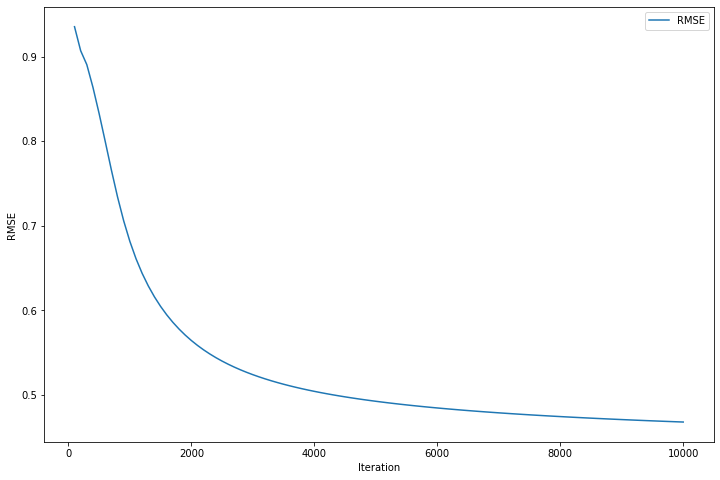

CPU times: user 1h 56min 2s, sys: 2h 21min 14s, total: 4h 17min 17s
Wall time: 50min 38s


In [21]:
%%time
model_svd = SVD(64, iterations=10000, lr=1e-4, verbose=True, weight_decay=1e-5)
model_svd.fit(user_item_exp)

timestamp = datetime.now()
model_svd.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_svd.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

In [22]:
get_similars(1, model_svd)

,name,category
0,Toy Story (1995),Animation|Children's|Comedy
1496,"Promise, The (La Promesse) (1996)",Drama
1522,Batman & Robin (1997),Action|Adventure|Crime
2183,Hero (1992),Comedy|Drama
2290,Waking Ned Devine (1998),Comedy
2555,After Life (1998),Drama
3214,Minnie and Moskowitz (1971),Action
3313,Song of Freedom (1936),Drama
3541,Roustabout (1964),Musical
3711,Rocketship X-M (1950),Sci-Fi


In [23]:
get_user_history(4, implicit_ratings)

,name,category
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
476,Jurassic Park (1993),Action|Adventure|Sci-Fi
1023,Die Hard (1988),Action|Thriller
1081,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
1180,Raiders of the Lost Ark (1981),Action|Adventure
1183,"Good, The Bad and The Ugly, The (1966)",Action|Western
1196,Alien (1979),Action|Horror|Sci-Fi|Thriller
1220,"Terminator, The (1984)",Action|Sci-Fi|Thriller
1366,Jaws (1975),Action|Horror
1885,Rocky (1976),Action|Drama


In [24]:
get_recommendations(4, model_svd)

,name,category
122,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama
550,Trial by Jury (1994),Thriller
838,Escape from L.A. (1996),Action|Adventure|Sci-Fi|Thriller
1167,Mediterraneo (1991),Comedy|War
1219,Local Hero (1983),Comedy
1516,"To Have, or Not (1995)",Drama
2482,Dead Ringers (1988),Drama|Thriller
2852,High Plains Drifter (1972),Western
3217,Snow Day (2000),Comedy
3644,"Long Walk Home, The (1990)",Drama


In [25]:
# %%time
# model_svds = SVDS(64, iterations=50, lr=1e-4, verbose=True, weight_decay=1e-5, save_every=10)

# model_svds.fit(user_item_exp)

# timestamp = datetime.now()
# model_svds.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
# model_svds.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

In [26]:
# get_similars(1, model_svds)

In [27]:
# get_user_history(4, implicit_ratings)

In [28]:
# get_recommendations(4, model_svds)

### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

KeyError: 'iter'

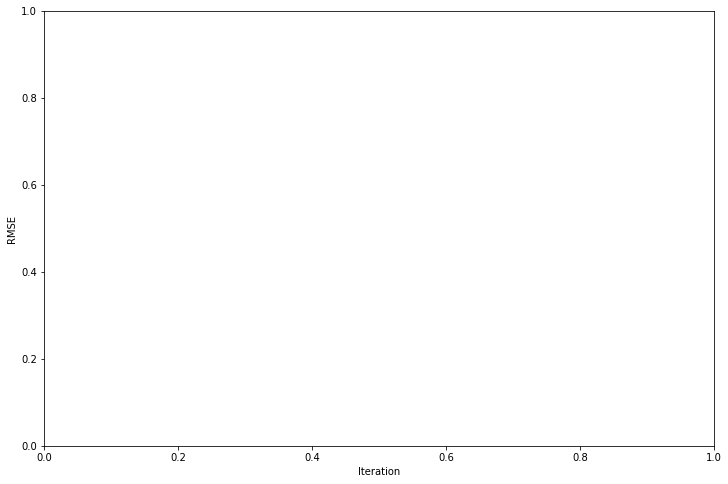

In [29]:
model_als = ALS(64, 5, 1e-4, 1e-5, True)

model_als.fit(user_item_t_csr)

timestamp = datetime.now()
model_als.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_als.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

In [ ]:
get_similars(1, model_als)

In [ ]:
get_user_history(4, implicit_ratings)

In [ ]:
get_recommendations(4, model_als)

### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных